In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
file_path = 'data_input_auto/WTI连1-连4月差拟合残差-美国RBOB汽油裂解.xlsx'
excel_data = pd.ExcelFile(file_path)
sheet = excel_data.parse('Sheet1')
sheet.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet.set_index('Date', inplace=True)


file_path1 = 'data_input_auto/predictions_rbob.xlsx'
excel_data1 = pd.ExcelFile(file_path1)
sheet1 = excel_data1.parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1.set_index('Date', inplace=True)

merged_data = sheet.join(sheet1[['美国RBOB汽油裂解']], how='outer')
merged_data.reset_index(inplace=True)
merged_data.rename(columns={'index': 'Date'}, inplace=True)

In [5]:
# 获取最后一个有效日期
last_day = merged_data.loc[merged_data['WTI M1-M4拟合残差/美国RBOB汽油裂解'].last_valid_index(), 'Date']
merged_data.set_index('Date', inplace=True)

# 生成目标日期范围
target_days = pd.date_range(start=last_day + pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
merged_data = merged_data.reindex(merged_data.index.union(target_days))
merged_data = merged_data[merged_data.index <= target_end]
merged_data.reset_index(inplace=True)
merged_data.rename(columns={'index': 'Date'}, inplace=True)

sheet_daily = merged_data.copy()

In [6]:

sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['WTI M1-M4拟合残差/美国RBOB汽油裂解'].notna()]

# 对数据进行线性填充
sheet_daily['库欣原油库存(预测/基于padd2拟合)'] = sheet_daily['库欣原油库存(预测/基于padd2拟合)'].interpolate(method='linear')
sheet_daily['EIA STEO全球石油去库幅度月度环比变化'] = sheet_daily['EIA STEO全球石油去库幅度月度环比变化'].interpolate(method='linear')

# 获取美国RBOB汽油裂解的最后一个有效日期
last_day_rbob = merged_data.loc[merged_data['美国RBOB汽油裂解'].last_valid_index(), 'Date']


sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day_rbob) | sheet_daily['美国RBOB汽油裂解'].notna()]
sheet_daily = sheet_daily[sheet_daily['Date'] <= last_day_rbob].copy()

sheet_daily.head(1)

,Date,WTI M1-M4拟合残差/美国RBOB汽油裂解,库欣原油库存(预测/基于padd2拟合),美元/卢布/7DMA30日环比,EIA STEO全球石油去库幅度月度环比变化,美国RBOB汽油裂解
3653,2014-08-01,2.2388,17982.0,0.046,NaN,12.95


In [7]:
# 使用 .loc 创建新列
sheet_daily.loc[:, '库欣原油库存(预测/基于padd2拟合)_提前1天'] = sheet_daily['库欣原油库存(预测/基于padd2拟合)'].shift(1)
sheet_daily.loc[:, '库欣原油库存(预测/基于padd2拟合)_提前2天'] = sheet_daily['库欣原油库存(预测/基于padd2拟合)'].shift(2) 
sheet_daily.loc[:, '库欣原油库存(预测/基于padd2拟合)_提前3天'] = sheet_daily['库欣原油库存(预测/基于padd2拟合)'].shift(3)
sheet_daily.loc[:, '库欣原油库存(预测/基于padd2拟合)_提前4天'] = sheet_daily['库欣原油库存(预测/基于padd2拟合)'].shift(4)
sheet_daily.loc[:, '美元/卢布/7DMA30日环比_提前20天'] = sheet_daily['美元/卢布/7DMA30日环比'].shift(20)

sheet_daily['库欣原油库存(预测/基于padd2拟合)_逆序'] = reverse_column(sheet_daily, '库欣原油库存(预测/基于padd2拟合)')
sheet_daily['库欣原油库存(预测/基于padd2拟合)_提前1天_逆序'] = reverse_column(sheet_daily, '库欣原油库存(预测/基于padd2拟合)_提前1天')
sheet_daily['库欣原油库存(预测/基于padd2拟合)_提前2天_逆序'] = reverse_column(sheet_daily, '库欣原油库存(预测/基于padd2拟合)_提前2天')
sheet_daily['库欣原油库存(预测/基于padd2拟合)_提前3天_逆序'] = reverse_column(sheet_daily, '库欣原油库存(预测/基于padd2拟合)_提前3天')
sheet_daily['库欣原油库存(预测/基于padd2拟合)_提前4天_逆序'] = reverse_column(sheet_daily, '库欣原油库存(预测/基于padd2拟合)_提前4天')


sheet_daily.loc[:, 'EIA STEO全球石油去库幅度月度环比变化_提前1天'] = sheet_daily['EIA STEO全球石油去库幅度月度环比变化'].shift(1)
sheet_daily.loc[:, 'EIA STEO全球石油去库幅度月度环比变化_提前2天'] = sheet_daily['EIA STEO全球石油去库幅度月度环比变化'].shift(2) 
sheet_daily.loc[:, 'EIA STEO全球石油去库幅度月度环比变化_提前3天'] = sheet_daily['EIA STEO全球石油去库幅度月度环比变化'].shift(3)
sheet_daily.loc[:, 'EIA STEO全球石油去库幅度月度环比变化_提前4天'] = sheet_daily['EIA STEO全球石油去库幅度月度环比变化'].shift(4)


sheet_daily.loc[:, 'EIA STEO全球石油去库幅度月度环比变化_推迟1天'] = sheet_daily['EIA STEO全球石油去库幅度月度环比变化'].shift(-10)
sheet_daily.loc[:, 'EIA STEO全球石油去库幅度月度环比变化_推迟2天'] = sheet_daily['EIA STEO全球石油去库幅度月度环比变化'].shift(-11)
sheet_daily.loc[:, 'EIA STEO全球石油去库幅度月度环比变化_推迟3天'] = sheet_daily['EIA STEO全球石油去库幅度月度环比变化'].shift(-9)
sheet_daily.loc[:, 'EIA STEO全球石油去库幅度月度环比变化_推迟4天'] = sheet_daily['EIA STEO全球石油去库幅度月度环比变化'].shift(-12)


sheet_daily = sheet_daily[sheet_daily['Date'] >= '2024-10-01'].copy()

In [8]:
sheet_daily.columns

Index(['Date', 'WTI M1-M4拟合残差/美国RBOB汽油裂解', '库欣原油库存(预测/基于padd2拟合)',
       '美元/卢布/7DMA30日环比', 'EIA STEO全球石油去库幅度月度环比变化', '美国RBOB汽油裂解',
       '库欣原油库存(预测/基于padd2拟合)_提前1天', '库欣原油库存(预测/基于padd2拟合)_提前2天',
       '库欣原油库存(预测/基于padd2拟合)_提前3天', '库欣原油库存(预测/基于padd2拟合)_提前4天',
       '美元/卢布/7DMA30日环比_提前20天', '库欣原油库存(预测/基于padd2拟合)_逆序',
       '库欣原油库存(预测/基于padd2拟合)_提前1天_逆序', '库欣原油库存(预测/基于padd2拟合)_提前2天_逆序',
       '库欣原油库存(预测/基于padd2拟合)_提前3天_逆序', '库欣原油库存(预测/基于padd2拟合)_提前4天_逆序',
       'EIA STEO全球石油去库幅度月度环比变化_提前1天', 'EIA STEO全球石油去库幅度月度环比变化_提前2天',
       'EIA STEO全球石油去库幅度月度环比变化_提前3天', 'EIA STEO全球石油去库幅度月度环比变化_提前4天',
       'EIA STEO全球石油去库幅度月度环比变化_推迟1天', 'EIA STEO全球石油去库幅度月度环比变化_推迟2天',
       'EIA STEO全球石油去库幅度月度环比变化_推迟3天', 'EIA STEO全球石油去库幅度月度环比变化_推迟4天'],
      dtype='object')

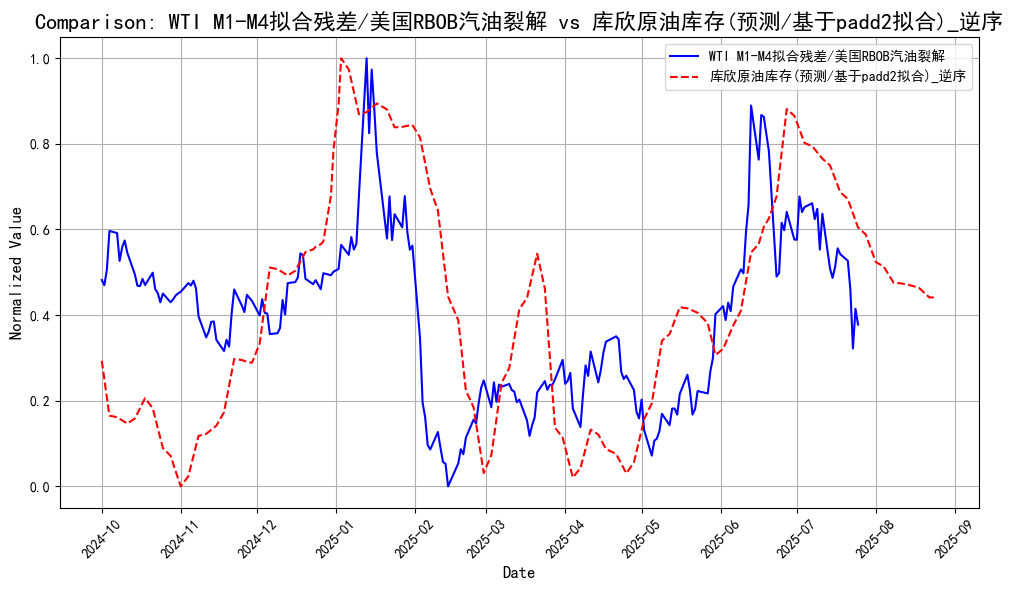

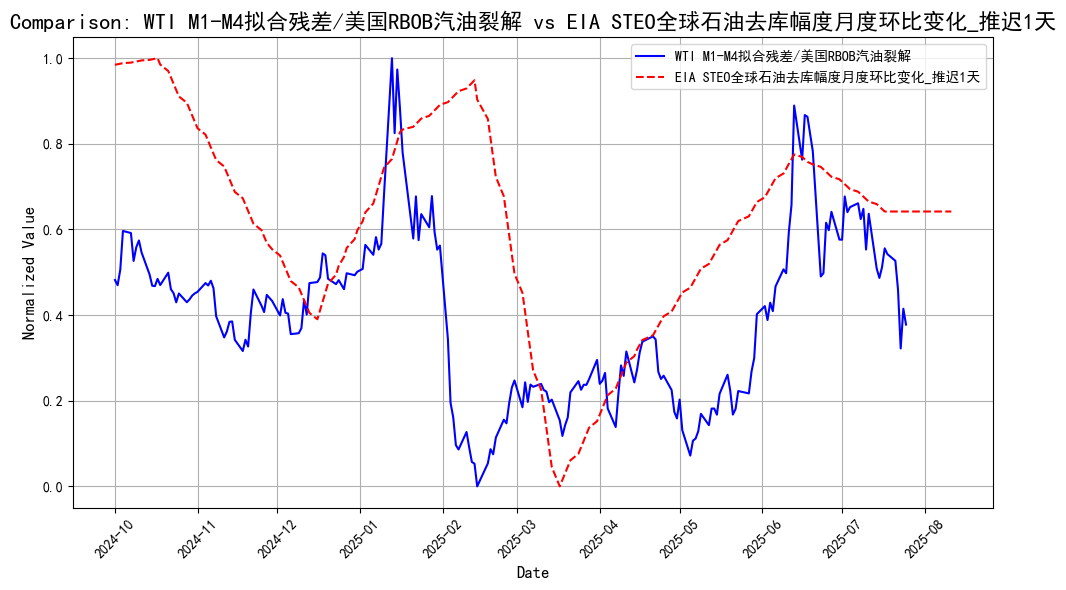

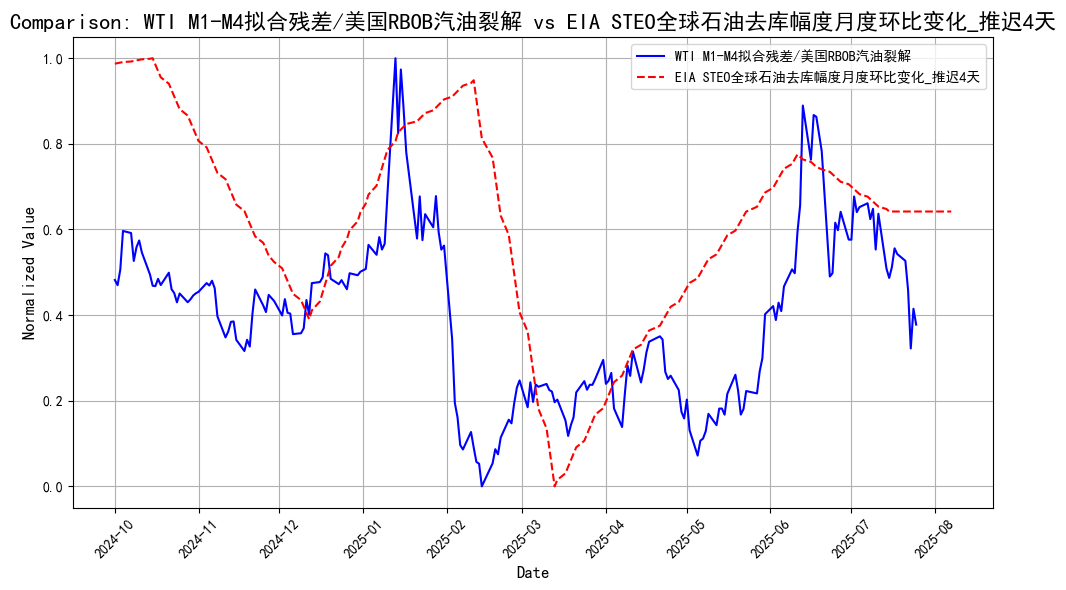

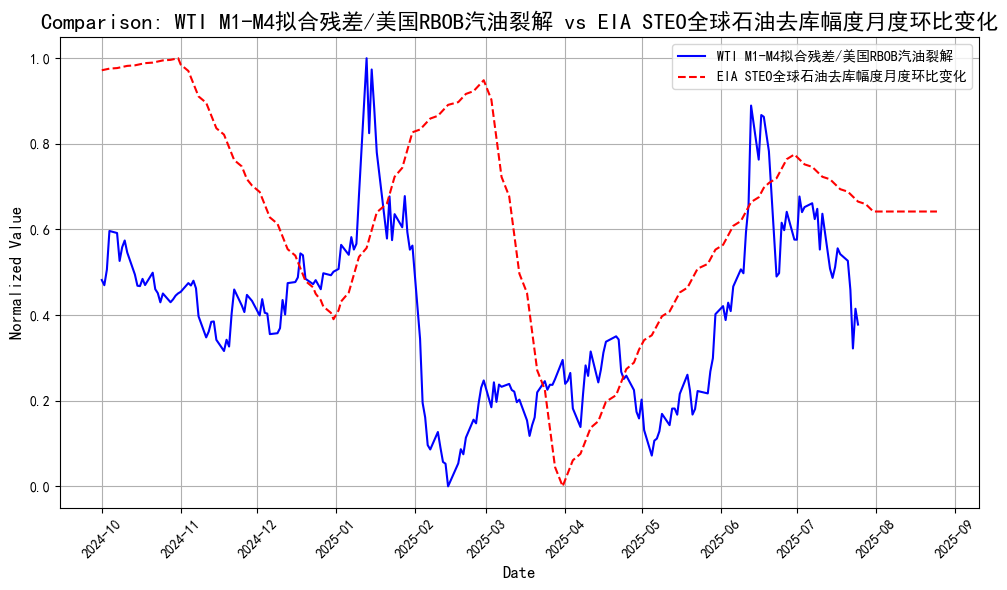

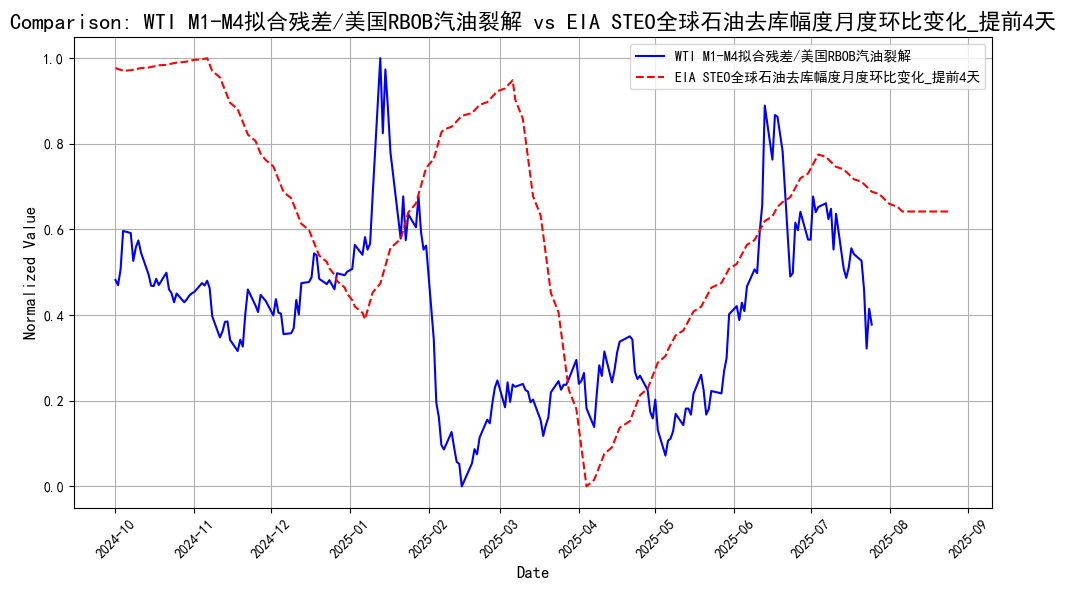

In [9]:
sheet_daily_plot = sheet_daily.set_index('Date')
sheet_daily_plot = sheet_daily_plot['2024-10-01':]

plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='WTI M1-M4拟合残差/美国RBOB汽油裂解', 
    compare_cols=[
        '库欣原油库存(预测/基于padd2拟合)_逆序',
#       '库欣原油库存(预测/基于padd2拟合)_提前1天_逆序',
#       '库欣原油库存(预测/基于padd2拟合)_提前2天_逆序', 
#       '库欣原油库存(预测/基于padd2拟合)_提前3天_逆序',
#       '库欣原油库存(预测/基于padd2拟合)_提前4天_逆序',
#       '美元/卢布/7DMA30日环比_提前20天',
        'EIA STEO全球石油去库幅度月度环比变化_推迟1天',
        'EIA STEO全球石油去库幅度月度环比变化_推迟4天',
        'EIA STEO全球石油去库幅度月度环比变化',
#       'EIA STEO全球石油去库幅度月度环比变化_提前1天',
#       'EIA STEO全球石油去库幅度月度环比变化_提前2天',
#       'EIA STEO全球石油去库幅度月度环比变化_提前3天',
       'EIA STEO全球石油去库幅度月度环比变化_提前4天',
       ]
)

In [10]:
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 3
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '库欣原油库存(预测/基于padd2拟合)_逆序',
#       '库欣原油库存(预测/基于padd2拟合)_提前1天_逆序',
#       '库欣原油库存(预测/基于padd2拟合)_提前2天_逆序', 
#       '库欣原油库存(预测/基于padd2拟合)_提前3天_逆序',
#       '库欣原油库存(预测/基于padd2拟合)_提前4天_逆序',
#       '美元/卢布/7DMA30日环比_提前20天',
        'EIA STEO全球石油去库幅度月度环比变化_推迟1天',
        'EIA STEO全球石油去库幅度月度环比变化_推迟4天',
        'EIA STEO全球石油去库幅度月度环比变化',
#       'EIA STEO全球石油去库幅度月度环比变化_提前1天',
#       'EIA STEO全球石油去库幅度月度环比变化_提前2天',
#       'EIA STEO全球石油去库幅度月度环比变化_提前3天',
       'EIA STEO全球石油去库幅度月度环比变化_提前4天',
]

predict_column = 'WTI M1-M4拟合残差/美国RBOB汽油裂解'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

In [11]:
# 初始化 StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)


# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.003,  # 降低学习率以避免过拟合
    'max_depth': 4,  # 减小树的深度以减少过拟合
    'min_child_weight': 5,  # 增加以防止过拟合
    'subsample': 0.8,  # 减小以增加模型稳定性
    'colsample_bytree': 0.8,  # 特征采样比例
    'gamma': 0.1,  # 增加以控制过拟合
    'reg_alpha': 0.1,  # L1正则化
    'reg_lambda': 1.0,  # L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
    'booster': 'gbtree',  # 使用树模型而不是线性模型
#    'n_estimators': 100,  # 增加树的数量
    'tree_method': 'auto'
}



num_boost_round = 2000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=500,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix =  model.predict(test_dmatrix)


train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")


##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:0.23941	train-rmse:1.05799
[500]	eval-rmse:0.63084	train-rmse:0.41489
[1000]	eval-rmse:0.76948	train-rmse:0.24135
[1500]	eval-rmse:0.81497	train-rmse:0.19357
[1999]	eval-rmse:0.82229	train-rmse:0.18579
训练集 MSE (DMatrix): 0.04, 训练集 R² (DMatrix): 0.9684
测试集 MSE (DMatrix): 0.6762, 测试集 R² (DMatrix): -13.3708


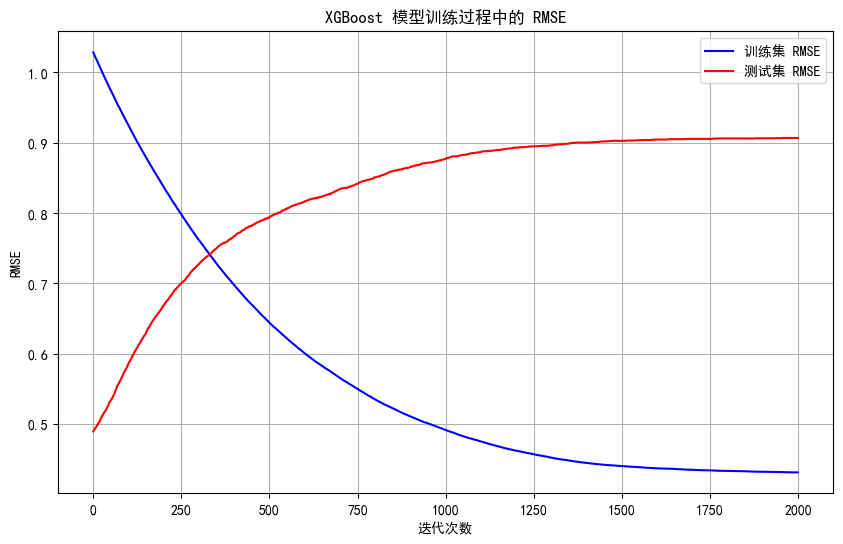

In [12]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################

# 确保数据拼接后索引是连续的，防止数据对不齐
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 对所有数据进行标准化（使用之前拟合的 scaler）
X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

# 对全部数据进行预测（X_train + X_test）
y_all_pred = model_all.predict(all_data_dmatrix)

# 对未来数据进行预测
y_future_pred_all = model_all.predict(future_dmatrix_all)

# 计算全部数据的 MSE 和 R² 分数
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

# 打印结果
print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred

# 存储未来预测结果
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:1.05046
[500]	train-rmse:0.42122
[1000]	train-rmse:0.24853
[1500]	train-rmse:0.20000
[1999]	train-rmse:0.18998
全部数据 MSE: 0.0414, 全部数据 R²: 0.9668


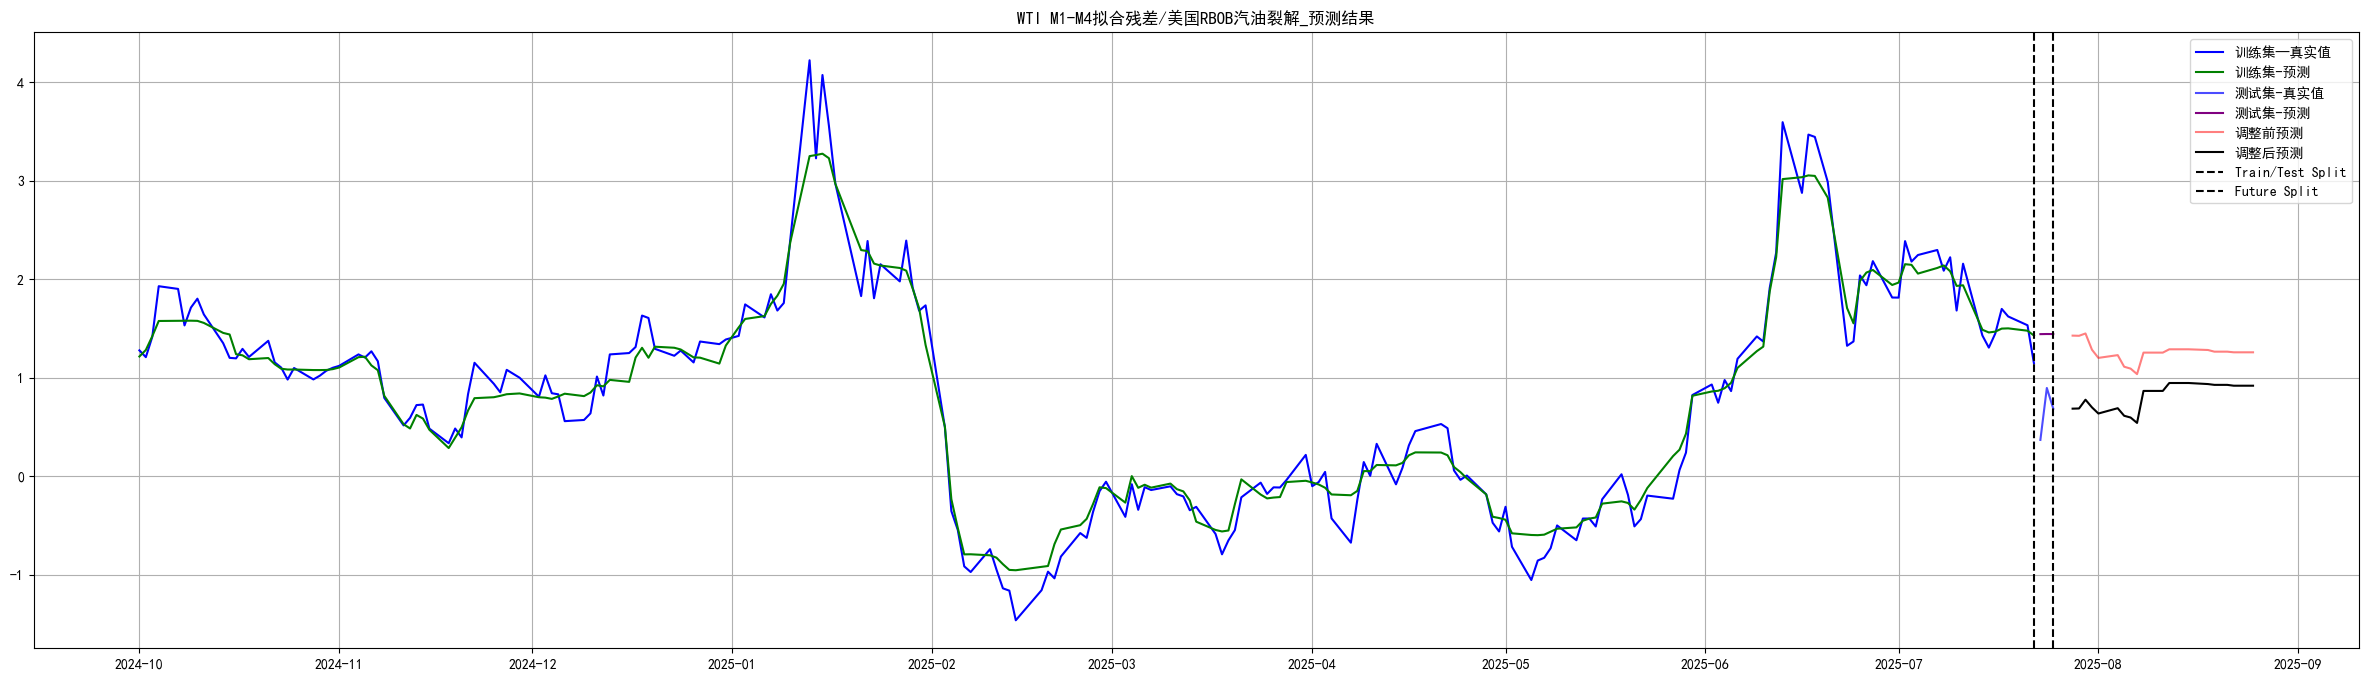

In [14]:
# 绘制调整后的结果对比图
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='调整前预测', color='red', alpha=0.5)
plt.plot(future_data['Date'], future_data['预测值_全量'], label='调整后预测', color='black')

plt.axvline(x=train_data['Date'].iloc[-1], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('WTI M1-M4拟合残差/美国RBOB汽油裂解_预测结果')
plt.legend()
plt.grid(True)
plt.show()


---

In [15]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/WTI_M1-M4拟合残差_美国RBOB汽油裂解_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/WTI_M1-M4拟合残差_美国RBOB汽油裂解_月度数据.xlsx', index=False,float_format= '%.4f')


In [16]:
merged_df_daily

,Date,真实值,预测值
226,2025/08/25,NaN,0.920290
225,2025/08/22,NaN,0.920290
224,2025/08/21,NaN,0.928806
223,2025/08/20,NaN,0.928806
222,2025/08/19,NaN,0.928806
...,...,...,...
4,2024/10/07,1.9034,NaN
3,2024/10/04,1.9308,NaN
2,2024/10/03,1.4166,NaN
1,2024/10/02,1.2102,NaN


---

In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "WTI M1-M4拟合残差/美国RBOB汽油裂解"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Lcel import update_excel_data
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "详情页"
identifier = "WTI M1-M4拟合残差/美国RBOB汽油裂解"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/07/31)
数据已成功更新到Excel文件
